In [109]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

import util, constants, draw, cam

np.random.seed(0)
torch.manual_seed(0)

from tqdm.notebook import tqdm


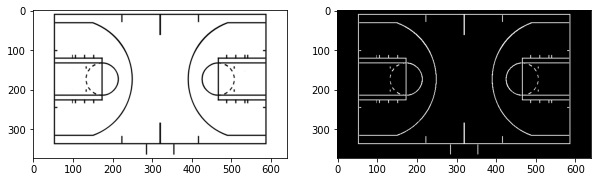

In [110]:
img = plt.imread('/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/court.png')
gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
binary = gray<0.1
plt.figure(figsize=(10,3))
plt.subplot(121);plt.imshow(img)
plt.subplot(122);plt.imshow(binary, cmap='gray')
plt.show()

# My custom warp perspective function

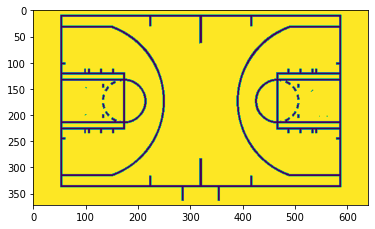

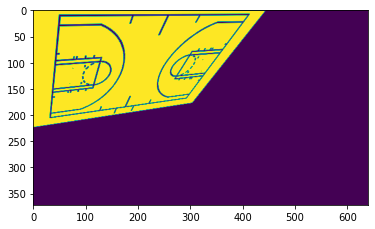

In [116]:
img1 = gray.astype(np.uint8).copy()*255

np.random.seed(100)
M = np.eye(3) + np.random.uniform(-.004, .003, size=(3,3))

img2 = cv2.warpPerspective(img1, M, img1.shape[::-1])
plt.imshow(img1);
plt.show()
plt.imshow(img2)
plt.show()

# img3 = np.zeros_like(img1)
# y = np.arange(img3.shape[0])
# x = np.arange(img3.shape[1])
# x, y = np.meshgrid(x, y)
# z = np.ones_like(x)
# X = np.stack([x,y,z], axis=-1)[..., None]
# MX = (M@X)
# MX = (MX[..., :2, 0]/MX[..., 2, 0, None]).astype(int)
# xp, yp = MX[..., 0], MX[..., 1]
# img3[y, x] = img1[yp, xp]
# plt.imshow(img3)

In [117]:
M

array([[ 9.99803835e-01, -2.05141430e-03, -1.02837686e-03],
       [ 1.91343293e-03,  9.96033032e-01, -3.14901615e-03],
       [ 6.95243593e-04,  1.78096929e-03,  9.96956946e-01]])

In [137]:
np.linalg.inv(M)

array([[ 9.98937151e-01,  4.39909053e-03, -8.23495324e-03],
       [-9.33732468e-03,  1.00816455e+00,  3.00240441e-01],
       [-6.99279548e-04, -1.75277058e-03,  9.99484846e-01]])

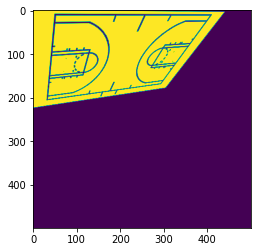

In [135]:
sift = cv2.SIFT_create() # sift = cv2.SIFT()
kp1,des1 = sift.detectAndCompute(img1, None)
kp2,des2 = sift.detectAndCompute(img2, None)

index_params = dict(algorithm=0, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good=[]
for m, n in matches:
    if m.distance<0.7*n.distance:
        good.append(m)
        
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)


M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

matchesMask = mask.ravel().tolist()

h, w, = gray.shape
pts = np.float32([[0,0], [0, h-1], [w-1, h-2],[w-1,0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)

temp = img1.copy()

temp = cv2.warpPerspective(temp, M, (500, 500))

plt.imshow(temp)